In [1]:
import re
import csv
import sys
import time
import spacy
import numpy as np
import pandas as pd
import random
import pickle
from fastcoref import FCoref, LingMessCoref
from taxonerd import TaxoNERD
from spacy.matcher import Matcher
from spacy.matcher import DependencyMatcher, PhraseMatcher
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%run -i "../utils.py"

C:\Users\lbeln\anaconda3\envs\3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Species:
    def __init__(self, scanner):
        self.scanner = scanner
        self.species_spans = None
        self.species_indices = None

    def update(self):
        if not self.scanner.sp_doc or not self.scanner.tn_doc:
            return
        # print("Updating Species Indices and Spans")
        t0 = time.time()
        self.species_spans, self.species_indices = self.load_species_spans()
        t1 = time.time()
        # print(f"Load Species Indices and Span: {t1-t0}s")
        
    def load_species_spans(self):
        spans = []
        indices = []
        for species_span in self.scanner.tn_doc.ents:
            l_species_i = species_span[0].i
            r_species_i = species_span[-1].i
            # print(f"Species Span: '{species_span}'")
            # print(f"Species L Index: {l_species_idx}")
            # print(f"Species R Index: {r_species_idx}")
            # print(f"Token Map Keys: {self.scanner.tk_map.keys()}")
            # print(f"TN Text: {self.scanner.tn_doc.text}")
            # print(f"SP Text: {self.scanner.sp_doc.text}")
            span = self.scanner.sp_doc[l_species_i:r_species_i+1]
            spans.append(span)
            indices += [token.i for token in span]
            
        return (spans, indices)

    def is_species(self, token):
        return token.i in self.species_indices
        
    def has_species(self, tokens):
        for token in tokens:
            if token.i in self.species_indices:
                return True
        return False

In [3]:
class Keywords:
    def __init__(self, scanner, literals, pos_types, threshold=0.7):
        self.scanner = scanner
        self.literals = literals
        self.threshold = threshold
        self.pos_types = pos_types
        self.keywords = [self.scanner.sp_nlp(literal) for literal in self.literals]
        self.keyword_indices = []

    def update(self):
        if not self.scanner.sp_doc or not self.scanner.sp_nlp:
            return
        # print("Updating Keyword Indices")
        t0 = time.time()
        self.keyword_indices = self.load_keyword_indices()
        t1 = time.time()
        # print(f"Keyword Indices: {t1-t0}s")
        
    def is_keyword(self, token):
        return token.i in self.keyword_indices

    def has_keyword(self, tokens):
        for token in tokens:
            if token.i in self.keyword_indices:
                return True
        return False

    def load_keyword_indices(self):
        indices = []
        for token in self.scanner.sp_doc:
            if token.pos_ not in self.pos_types or self.do_not_check(token):
                continue
            # Fast Check
            if token.lemma_ in self.literals:
                indices.append(token.i)
                continue
            # Comparing Similarity
            lemma = self.scanner.sp_nlp(token.lemma_)
            for keyword in self.keywords:
                similarity = keyword.similarity(lemma)
                if similarity > self.threshold:
                    indices.append(token.i)
        return indices

    def find_keyword_indices(self, tokens):
        indices = []
        for token in tokens:
            if token.pos_ not in self.pos_types or self.do_not_check(token):
                continue
            # Fast Check
            if token.lemma_ in self.literals:
                indices.append(token.i)
                continue
            # Comparing Similarity
            lemma = self.scanner.sp_nlp(token.lemma_)
            for keyword in self.keywords:
                similarity = keyword.similarity(lemma)
                if similarity > self.threshold:
                    indices.append(token.i)
        return indices

    def do_not_check(self, token):
        return len(token) <= 5 or re.match('^[\w]+$', token.text) is None

In [4]:
class ChangeKeywords(Keywords):
    def __init__(self, scanner):
        super().__init__(scanner, {"increase", "decrease", "change", "shift", "cause", "produce"}, ["NOUN", "VERB"], 0.6)

In [5]:
class References:
    def __init__(self, scanner, texts=None):
        self.scanner = scanner
        self.predictions = None
        self.cluster_map = None
        self.text_size_in_tokens = 100
        if texts:
            self.update(texts)

    def update(self, text):
        if not self.scanner.tn_doc:
            return
        # print("Updating Predictions")
        # t0 = time.time()
        
        self.predictions = self.scanner.fcoref.predict(texts=[text])
        # t1 = time.time()
        # print(f"Predictions: {t1-t0}s")

        # print("Updating Cluster Map")
        # t0 = time.time()
        self.cluster_map = self.load_cluster_map(self.predictions)
        # t1 = time.time()
        # print(f"Cluster Map: {t1-t0}s")

    def load_cluster_map(self, predictions):
        cluster_map = {}
        for prediction in predictions:
            clusters = prediction.get_clusters(as_strings=False)
            for cluster in clusters:
                print(cluster)
                
                # It's a cluster of spans,
                # but instead it'll be 'converted' into a cluster of tokens.
                token_cluster = []
            
                for span in cluster:
                    span_words = self.scanner.tn_doc.text[span[0]:span[1]].split()
                    # print(span_words)
                    
                    word_index = span[0]
                    for i in range(len(span_words)):
                        word = span_words[i]
                        if word_index not in self.scanner.tk_map:
                            continue
                        token_cluster.append(self.scanner.tk_map[word_index])
                        word_index += len(word) + 1

                # print(token_cluster)
                    
                # Mapping
                for token in token_cluster:
                    cluster_map[token.i] = list(filter(lambda t: t != token, token_cluster))
        return cluster_map
            
    def get_references(self, tokens):
        refs = []
        for token in tokens:
            index = token.i
            if index in self.cluster_map:
                refs += self.cluster_map[index]
        return refs

    def same_reference(self, token_a, token_b):
        if token_a.lemma_.lower() == token_b.lemma_.lower():
            return True
        if token_a.i in self.cluster_map and token_b in self.cluster_map[token_a.i]:
            return True
        if token_b.i in self.cluster_map and token_a in self.cluster_map[token_b.i]:
            return True
        return False

    def same_reference_span(self, span_a, span_b):
        if span_a.text.lower() == span_b.text.lower():
            return True
        for token_a in span_a:
            for token_b in span_b:
                if self.same_reference(token_a, token_b):
                    return True
        return False

In [6]:
class Scanner():
    def __init__(self):
        # Tools
        self.sp_nlp = spacy.load("en_core_web_lg")
        self.tn_nlp = TaxoNERD(prefer_gpu=False).load(model="en_ner_eco_biobert", exclude=["tagger", "parser", "attribute_ruler", "lemmatizer"])
        self.fcoref = FCoref(enable_progress_bar=False, device='cpu')
        self.sp_doc = None
        self.tn_doc = None
        self.tk_map = None
        
        # Helpers
        self.species = Species(self)
        self.references = References(self)
        self.changes = ChangeKeywords(self)
    
    def update(self, doc):
        self.sp_doc = doc
        self.tn_doc = self.tn_nlp(doc.text)
        self.tk_map = self.load_token_map()
        self.references.update(doc.text)
        self.species.update()

    def load_token_map(self):
        # Maps Characters to Tokens
        tk_map = {}
        for token in self.tn_doc:
            tk_map[token.idx] = token
        return tk_map

    def get_full_species(self):
        full_species = [*self.species.species_spans]
        full_indices = [*self.species.species_indices]
        
        for k, v in self.references.cluster_map.items():
            if k in self.species.species_indices:
                for token in v:
                    if token.i not in full_indices:
                        token_span = self.tn_doc[token.i:token.i+1]
                        full_species.append(token_span)
                        full_indices.append(token.i)
            if self.species.has_species(v):
                if k not in full_indices:
                    token_span = self.tn_doc[k:k+1]
                    full_species.append(token_span)
                    full_indices.append(k)
        
        return (full_species, full_indices)

    def get_points(self, verbose=False):
        if verbose:
            print("\n\n\n")
        points = 0

        if verbose:
            print("Cluster Map")
            print(self.references.cluster_map)

        # This dictionary contains the species that have been seen already
        # and a number indicating the amount of times they have been visited.
        # The key is a tuple wherein the first index contains the start of the span
        # and the second (last) index contains the end of the span. The span is the
        # species. The value is the number of visitations for that species.
        visited_species = {}

        # This is used to quickly find nearby species.
        species_spans, species_indices = self.get_full_species()
        if verbose:
            print(f"Species Spans:")
            print("\t"+"\n\t".join([f"'{span.text}' from {span[0].i}-{span[-1].i}" for span in species_spans]))
            print("--")
        
        for species_span in species_spans:
            if verbose:
                print("\nLoop")
                print(f"Sentence of Species: {species_span.sent.text}")
                print(f"Species: '{species_span.text}' from {species_span[0].i}-{species_span[-1].i}")
                
                # This (visited_species) stores a tuple with the start and end token indices, 
                # which is why the -1 indexing is not being used here.
                print(f"\tVisited Species:")
                print("\t\t"+"\n\t\t".join([f"'{self.sp_doc[sp[0]:sp[1]+1]}' from {sp[0]}-{sp[1]} visited {n} times." for sp, n in visited_species.items()]))
                print("--")

            if verbose:
                print("Expanding Species")

            # Take the sentence "blue whale", for example. TaxoNerd might recognize
            # "whale", but the adjective "blue" is also important in correctly identifying
            # the species being referenced. This is why I'm expanding the species.
            if species_span[0].text.lower() in ["species"]:
                i = species_span[0].i
                j = i
                while j > 0:
                    prev_token = self.sp_doc[j-1]
                    if prev_token.pos_ not in ["NOUN", "ADJ", "PROPN", "SYM"]:
                        break
                    species_span = self.sp_doc[j-1:i+1]
                    if verbose:
                        print(f"\Expanding Species - Now: {species_span}")
                    j -= 1

            if verbose:
                print(f"Sentence of (Final) Expanded Species: {species_span.sent.text}") # Should be the same as before.
                print(f"Final Expanded Species: '{species_span.text}' from {species_span[0].i}-{species_span[-1].i}")

            if verbose:
                print("Looking for Past References")
            
            past_visits = 0
            for sp in visited_species.keys():
                visited_species_span = self.sp_doc[sp[0]:sp[1]+1]
                if verbose:
                    print(f"\tComparing '{species_span.text}' and '{visited_species_span.text}'")
                
                if self.references.same_reference_span(species_span, visited_species_span):
                    past_visits = visited_species[sp]
                    if verbose:
                        print(f"\t'{species_span.text}' == '{visited_species_span.text}'")
                        print(f"\t\tNumber of Past Visits: {past_visits}")
                    visited_species[sp] += 1
                    break

            if verbose:
                print(f"Past Visits: {past_visits}")
            if past_visits == 0:
                visited_species[(species_span[0].i, species_span[-1].i)] = 1

            # The points will begin to inflate at a certain point, so to reduce
            # those effects, I'm limiting the number of references. This might not
            # matter anymore with the changes I'm making, though.
            if past_visits > 50:
                if verbose:
                    print(f"Past Visits Exceed 50, Continue")
                continue

            # These contains the indices of the tokens that start and end
            # the sentence.
            li = species_span[0].sent.start
            ri = species_span[-1].sent.end

            # This contains the indices of the tokens that start and end
            # the species span.
            sli = species_span[0].i
            sri = species_span[-1].i

            # These are the indices of the tokens to the left of the species span,
            # and the indices of the tokens to the right of the species span.
            l_token_indices = set([token.i for token in self.sp_doc[li:sli]])
            r_token_indices = set([token.i for token in self.sp_doc[sri+1:ri]])

            # Nearby Actions (Modification)
            change_indices = set(self.changes.find_keyword_indices(self.sp_doc[li:ri]))
            if verbose:
                print(f"Change (Causative) Verbs in Sentence: {[self.sp_doc[i].text for i in change_indices]}")

            # Now that I'm thinking about it, I'm not sure why I make the distinction between the left and right.
            # I'll leave it for now in case it becomes useful later on.
            l_changes = l_token_indices.intersection(change_indices)
            r_changes = r_token_indices.intersection(change_indices)
            if verbose:
                print(f"Change (Causative) Verbs in L-Sentence: {[self.sp_doc[i].text for i in l_changes]}")
                print(f"Change (Causative) Verbs in R-Sentence: {[self.sp_doc[i].text for i in r_changes]}")

            # There must be a change. If there's none,
            # we move onto the next species in the paper/abstract.
            if not l_changes and not r_changes:
                continue
                
            # Nearby Species (Interaction)
            l_species = l_token_indices.intersection(species_indices)
            r_species = r_token_indices.intersection(species_indices)
            if verbose:
                print(f"Species in L-Sentence: {[self.sp_doc[i].text for i in l_species]}")
                print(f"Species in R-Sentence: {[self.sp_doc[i].text for i in r_species]}")

            # There must be a species. If there's none,
            # we move onto the next species in the paper/abstract.
            if not l_species and not r_species:
                continue

            # Adding Points
            points += 10 * (past_visits + 1)
            if verbose:
                print(f"Added {10 * (past_visits + 1)} Points for Species, Now {points}")

        if verbose:
            print(f"Points: {points}")
        
        # Adjustments
        number_sentences = len(list(self.sp_doc.sents))
        if number_sentences == 0:
            points = 0
        else:
            points /= number_sentences
        if verbose:
            print(f"Adjusted Points ({len(list(self.sp_doc.sents))} Sentences): {points}")

        if verbose:
            print(f"\tVisited Species:")
            print("\t\t"+"\n\t\t".join([f"'{self.sp_doc[sp[0]:sp[1]+1]}' from {sp[0]}-{sp[1]} visited {n} times." for sp, n in visited_species.items()]))
            print("--")
        
        if len(visited_species) < 3:
            if verbose:
                print("Less Than 3 Species Visited, 0 Points")
            return 0
        if verbose:
            print(f"{points} Points")
        return points

In [7]:
def score_dataset(name, save_output=False, version=""):
    # Redirect Print Statements
    # https://stackoverflow.com/questions/7152762/how-to-redirect-print-output-to-a-file
    if save_output:
        initial_stdout = sys.stdout
        f = open(f'./Print{name}{"" if not version else f"-{version}"}.txt', 'w')
        sys.stdout = f
        sys.stdout.reconfigure(encoding='utf-8')

    # Load Dataset
    data = load_preprocessed_dataset(name)
    print(f"Data Shape: {data.shape}")

    # We'll be running the points algorithm
    # on the abstracts of these papers.
    texts = list(data['Abstract'].to_numpy())
    number_texts = len(texts)
    print(f"Number of Texts: {number_texts}")
    
    # The scores for each paper will be stored here,
    # we'll set this as a column of the dataframe.
    scores = []
    
    # Scan and Evaluate Documents
    scanner = Scanner()
    for i, doc in enumerate(scanner.sp_nlp.pipe(texts)):
        print(f"{i+1}/{number_texts} - {data.iloc[i]['Title']}")
        scanner.update(doc)

        # Empty string literals cause errors, so it's
        # being handled here.
        if not scanner.sp_doc or not scanner.tn_doc:
            scores.append(0)
        else:
            points = scanner.get_points(verbose=save_output)
            scores.append(points)

        if not save_output:
            clear_output(wait=True)

    # Reset Standard Output
    if save_output:
        sys.stdout = initial_stdout
        f.close()

    data["Score"] = scores
    data.sort_values(by='Score', ascending=False, inplace=True)
    return data

In [9]:
# Score Datasets
dataset_names = ["Examples", "Baseline-1", "SubA", "SubAFiltered", "SubB", "SubBFiltered", "C", "CFiltered", "D", "DFiltered"]
for name in dataset_names:
    scored_data = score_dataset(name, save_output=True, version='')
    store_scored_dataset(scored_data, name, version='')

06/11/2025 03:10:30 - INFO - 	 missing_keys: []
06/11/2025 03:10:30 - INFO - 	 unexpected_keys: []
06/11/2025 03:10:30 - INFO - 	 mismatched_keys: []
06/11/2025 03:10:30 - INFO - 	 error_msgs: []
06/11/2025 03:10:30 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M
06/11/2025 03:10:31 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 11.63 examples/s]
06/11/2025 03:10:32 - INFO - 	 ***** Running Inference on 1 texts *****
06/11/2025 03:10:52 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00,  8.41 examples/s]
06/11/2025 03:10:52 - INFO - 	 ***** Running Inference on 1 texts *****
06/11/2025 03:10:57 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 16.50 examples/s]
06/11/2025 03:10:58 - INFO - 	 ***** Running Inference on 1 texts *****
06/11/2025 03:11:03 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 11.86 examples/s]
06/11/2025 03:11:03 - INFO - 	 ***** Running Inference 

Accuracy: 66.67%


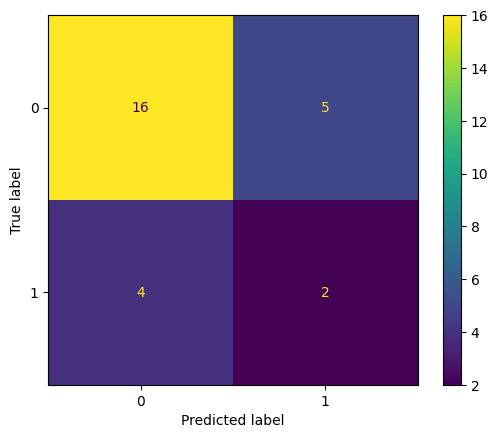

In [10]:
measurements = measure_method_by_threshold(
    output_fp="./ScoredBaseline-1.csv",
    output_threshold=100,
    target_threshold=3,
    verbose=False
)

print(f"Accuracy: {measurements['accuracy'] * 100:.2f}%")
cm = ConfusionMatrixDisplay(confusion_matrix=measurements['confusion_matrix'])
cm.plot()
plt.show()